In [738]:
import torch
import utils
import numpy as np
import torch.nn as nn
import json
import config as C
import os
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader

In [ ]:
3384, 2710

In [10]:
torch.cuda.is_available()

True

In [45]:
class PKUDataset(Dataset):
    
    def __init__(self, image_names):
        train_annotations_all = utils.load_train_annotations()
        self.image_annotations = {name: train_annotations_all[name] for name in image_names}
        
        camera_matrix = utils.get_camera_matrix()
        car_center_2d, car_center_3d = [], []
        for image_name, anns in self.image_annotations.items():
            for x, y, z in zip(anns["xs"], anns["ys"], anns["zs"]):
                v3 = np.array([x, y, z])
                v2 = camera_matrix.dot(v3)
                v2 /= v2[2]
                car_center_2d.append(v2[:2])
                car_center_3d.append(v3)
        self.car_center_2d = car_center_2d
        self.car_center_3d = car_center_3d
    
    def __len__(self):
        return len(self.car_center_2d)
    
    def __getitem__(self, idx):
        return dict(
            car_center_2d=self.car_center_2d[idx], 
            car_center_3d=self.car_center_3d[idx]
        )

In [46]:
with open(os.path.join(C.CV_DIR, 'fold-1', 'train_objects_bbox_single_class_train.json')) as f:
    train_gt = json.load(f)
with open(os.path.join(C.CV_DIR, 'fold-1', 'train_objects_bbox_single_class_valid.json')) as f:
    valid_gt = json.load(f)

In [81]:
train_ds = PKUDataset([os.path.basename(image["file_name"]).split(".")[0] for image in train_gt["images"]])
valid_ds = PKUDataset([os.path.basename(image["file_name"]).split(".")[0] for image in valid_gt["images"]])

In [620]:
BATCH_SIZE = 16384

In [621]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, drop_last=False)

In [622]:
len(train_dl), len(valid_dl)

(2, 1)

In [84]:
for batch in train_dl:
    break

In [914]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        k = utils.get_camera_matrix()
        
        self.fx = k[0, 0]
        self.fy = k[1, 1]
        self.cx = k[0, 2]
        self.cy = k[1, 2]
        
        self.n = nn.Parameter(torch.Tensor([0., -1., 0.]))
        torch.nn.init.normal_(self.n.data)
        
        self.h = nn.Parameter(torch.Tensor([0.0]))
        torch.nn.init.normal_(self.h.data)
        
    def forward(self, v2):
        u, v = v2[:, 0], v2[:, 1]
        nx, ny, nz = self.n
        
        n_norm = torch.norm(self.n)
        z = (n_norm * (n_norm - self.h)) / (nx * (u - self.cx) / self.fx + ny * (v - self.cy) / self.fy + nz)
        x = z * (u - self.cx) / self.fx
        y = z * (v - self.cy) / self.fy
        
        v3 = torch.stack((x, y, z), dim=1)
        return v3

In [946]:
model = Model().float().cuda()

In [687]:
o = model(torch.Tensor([[1.6862379e+03, 1354]]).double().cuda())

In [487]:
o.detach().cpu().numpy()[0]

array([ 0.00000000e+00, -1.00000000e+00,  2.34131557e+03])

In [456]:
k = utils.get_camera_matrix()

In [457]:
k

array([[2.3045479e+03, 0.0000000e+00, 1.6862379e+03],
       [0.0000000e+00, 2.3058757e+03, 1.3549849e+03],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [458]:
v2 = k.dot(o.detach().cpu().numpy()[0])
v2 / v2[2]

array([1.68623792e+03, 3.01000000e+03, 1.00000000e+00])

In [388]:
model(torch.Tensor([[3000, 500]]).double().cuda())

tensor([[ 0.7687, -0.5000,  1.3485]], device='cuda:0', dtype=torch.float64,
       grad_fn=<StackBackward>)

In [394]:
model(torch.Tensor([[3000, 30000]]).double().cuda())

tensor([[-0.0229, -0.5000, -0.0402]], device='cuda:0', dtype=torch.float64,
       grad_fn=<StackBackward>)

In [793]:
def loss_fn(a, b):
    abs = torch.abs(a - b)
    idx = abs < 1
    loss = abs[idx].sum() + 0.1 * abs[~idx].sum()
    return loss / len(a)
#     loss = torch.clamp(, 0, 10)
#     return torch.mean(loss)

In [947]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [948]:
N_EPOCHS = 1000

In [949]:
loss_history = []

In [950]:
from IPython.display import clear_output

In [962]:
X = torch.Tensor(train_ds.car_center_2d).float().cuda()
y = torch.Tensor(train_ds.car_center_3d).float().cuda()

In [952]:
y[:, 1:] = torch.log(y[:, 1:])

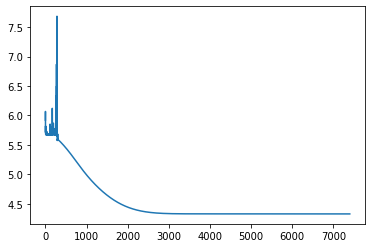

KeyboardInterrupt: 

In [953]:
it = 0
while True:
    #for batch in train_dl:
    optimizer.zero_grad()
#     for k in batch:
#         batch[k] = batch[k].double().cuda()
    outputs = model(X)
    loss = loss_fn(outputs, y)
    loss.backward()
#         for p in model.parameters():
#             p.grad = p.grad / torch.norm(p.grad)
    optimizer.step()
    loss_history.append(loss.item())
    if it % 100 == 0:
        clear_output()
        plt.plot(loss_history)
        plt.show()
    it += 1

In [ ]:
loss_history[-10:]

In [956]:
y[:, 1:] = torch.exp(y[:, 1:])

In [957]:
outputs[:, 1:] = torch.exp(outputs[:, 1:])

In [963]:
y

tensor([[ -8.9586,   7.4417,  34.3233],
        [ -9.7642,   9.0748,  44.7441],
        [ -8.9896,  10.5474,  55.1644],
        ...,
        [-32.5461,   8.2850,  50.6212],
        [ -4.4614,   6.6292,  32.8667],
        [-27.0011,   8.8790,  53.0800]], device='cuda:0')

In [959]:
outputs

tensor([[-1.3230e+00,  3.0012e+00,  1.5901e+02],
        [-1.0464e+00,  2.6447e+00,  1.2094e+02],
        [-7.2858e-01,  2.3510e+00,  8.7435e+01],
        ...,
        [-7.9760e+00,  7.6169e+00,  2.4416e+05],
        [-5.8360e-01,  2.3802e+00,  7.3652e+01],
        [-4.2302e+00,  4.0191e+00,  4.0885e+03]], device='cuda:0',
       grad_fn=<CopySlices>)

In [960]:
d = torch.sqrt(((outputs - y) ** 2).sum(dim=1)).detach().cpu().numpy()

In [961]:
(d < 0.1).sum()

0

In [813]:
len(d)

39639

In [822]:
model.h

Parameter containing:
tensor([6.7837], device='cuda:0', requires_grad=True)

In [823]:
model.n

Parameter containing:
tensor([ 0.0151, -0.6626,  0.0376], device='cuda:0', requires_grad=True)

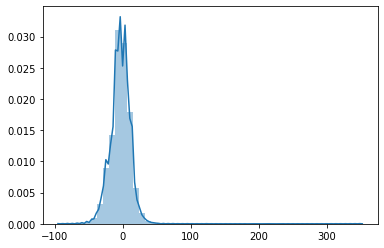

In [742]:
sns.distplot(y[:, 0].cpu().numpy())

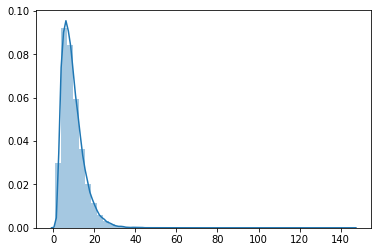

In [747]:
sns.distplot(y[:, 1].cpu().numpy())

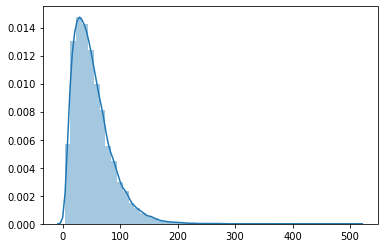

In [748]:
sns.distplot(y[:, 2].cpu().numpy())

In [287]:
n_norm = torch.norm(model.n)
v2_w = n_norm * (n_norm - model.h)

In [288]:
n_norm

tensor(0.6685, device='cuda:0', dtype=torch.float64, grad_fn=<NormBackward0>)

In [289]:
(3.6564 ** 2 + 1.0995 ** 2 + 0.9282 ** 2) ** 0.5

3.9293404599245405

In [184]:
loss_history

[1128.1505490690508,
 1115.728173533081,
 1277.052759345029,
 1172.603231860738,
 1369.5681682467623,
 867.4015724989572,
 1157.874637351509,
 1351.626623951973,
 1022.4711976427125,
 1435.8392192249048,
 1181.3573949054717,
 1402.8295965518585,
 1368.0015364033025,
 1500.413170683981,
 1387.2436249816828,
 1104.1527299185466,
 1296.1676634426713,
 1158.4283502432766,
 1426.514300720668,
 1088.7401548469193,
 1060.6589717838517,
 999.8164919670544,
 964.1136608364644,
 993.3700641393658,
 1280.4099918466686,
 1085.191785361478,
 1070.6516046444447,
 812.3780787987871,
 1009.9914139612221,
 1132.5598766724604,
 840.9978634104551,
 1044.9445976197294,
 1060.4877848281758,
 909.089813642007,
 1197.91955094759,
 1208.570756604907,
 1258.0029859941446,
 1033.990450344785,
 1280.232476719686,
 965.2645189728631,
 842.3437736235423,
 958.2171826331819,
 944.0229875570955,
 1020.9012401820816,
 940.8019239127804,
 1117.9634834586698,
 944.739557012003,
 985.9526606547755,
 852.2986556842303,
 

In [821]:
list(model.parameters())

[Parameter containing:
 tensor([ 0.0151, -0.6626,  0.0376], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([6.7837], device='cuda:0', requires_grad=True)]

In [57]:
model.inv_camera_matrix

tensor([[ 4.3392e-04,  0.0000e+00, -7.3170e-01],
        [ 0.0000e+00,  4.3367e-04, -5.8762e-01],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [58]:
torch.inverse(model.inv_camera_matrix)

tensor([[2.3045e+03, -0.0000e+00, 1.6862e+03],
        [0.0000e+00, 2.3059e+03, 1.3550e+03],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])

In [5]:
k = utils.get_camera_matrix()

In [6]:
k

array([[2.3045479e+03, 0.0000000e+00, 1.6862379e+03],
       [0.0000000e+00, 2.3058757e+03, 1.3549849e+03],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [8]:
np.linalg.inv(k)

array([[ 4.3392461e-04,  0.0000000e+00, -7.3170012e-01],
       [ 0.0000000e+00,  4.3367472e-04, -5.8762270e-01],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]], dtype=float32)

In [15]:
anns = utils.load_train_annotations()

In [16]:
anns

{'ID_8a6e65317': {'model_types': [16, 56, 70, 70, 46],
  'yaws': [0.254839, 0.181647, 0.163072, 0.141942, 0.163068],
  'pitches': [-2.57534, -1.46947, -1.56865, -3.1395, -2.08578],
  'rolls': [-3.10256, -3.12159, -3.11754, 3.11969, -3.11754],
  'xs': [7.96539, 9.60332, 10.39, -9.59236, 9.83335],
  'ys': [3.20066, 4.66632, 11.2219, 5.13662, 13.2689],
  'zs': [11.0225, 19.339, 59.7825, 24.7337, 72.9323]},
 'ID_337ddc495': {'model_types': [66, 60, 28, 66, 46, 70, 2, 50],
  'yaws': [0.163988,
   0.112482,
   0.186114,
   0.0209679,
   0.195428,
   0.195568,
   0.112481,
   0.112334],
  'pitches': [0.192169,
   -2.96307,
   0.35728,
   0.218402,
   -2.84778,
   2.13627,
   0.504593,
   0.406024],
  'rolls': [-3.12112,
   3.13951,
   -3.10043,
   3.12213,
   -3.13394,
   -3.13969,
   3.13951,
   3.13547],
  'xs': [-3.17424,
   -14.7269,
   -7.49818,
   -10.3531,
   -22.7711,
   -44.5869,
   -24.6755,
   -22.1187],
  'ys': [6.55331,
   10.2077,
   10.3112,
   11.2453,
   13.0704,
   11.2091,


In [19]:
v3 = np.array([7.96539, 3.20066, 11.0225])

In [20]:
v2 = k.dot(v3)
v2 /= v[2]

In [21]:
v2

array([3.35161532e+03, 2.02455386e+03, 1.00000000e+00])